# **Projet 4 : Anticipate the electricity consumption needs of buildings**

# Table of Contents

Context

Goals

Advice

Connections

Libraries and dataframe import

Dataframe's info

Description and data cleaning

  1. Difference between columns in two datasets
  2. Removal of irrelevant variables in view of their descriptions and renaming
  3. Concatenation
  4. Visualization of the filling rate

Work on variables
  1. Removal of irrelevant and insufficiently informed variables
  2. Removal of buildings intended for housing
  3. Removal of variables with unwanted units
  4. Variable DefaultData
  5. Variable ComplianceStatus
  6. Removal of highly correlated variables 
  7. Removal of duplicates

Investigation of variables
  
  1. Analysis of the distribution of numerical variables

     . Focus on targets

     . Log target transformation

     . Removing outliers from targets

     . Removal of highly correlated variables after removal of outliers

  2. Analysis of categorical variables


Energy consumption VS Characteristics of buildings

Geographic analysis

Exporting the dataset

# Context


You work for the city of Seattle. To achieve its goal of being a neutral city in carbon emissions by 2050, your team is paying close attention to the emissions of buildings not intended for housing.

Thorough readings were carried out by your agents in 2015 and 2016. However, these readings are expensive to obtain, and from those already taken, you want to try to predict the CO2 emissions and the total energy consumption of buildings. for which they have not yet been measured.

The prediction will be based on the declarative data of the commercial exploitation permit (size and use of buildings, mention of recent works, date of construction, etc.)

The relevance of the "ENERGY STAR Score" for predicting emissions will be assessed. It is tedious to calculate with the approach currently used by the team.

# Goals


. Perform a short exploratory analysis.

. Test different prediction models in order to best answer the problem.

# Advice

"The goal is to do without annual consumption readings (beware of data leaks), but nothing prevents you from deducing simpler variables (nature and proportions of energy sources used).

Pay close attention to the treatment of the different variables, both to find new information (can we deduce interesting things from a simple address?) And to optimize performance by applying simple transformations to the variables (normalization, going to log, etc.).

Implement a rigorous evaluation of regression performance, and optimize hyperparameters and ML algorithm choice using cross-validation. "

# Connections

. Data : https://www.kaggle.com/city-of-seattle/sea-building-energy-benchmarking#2015-building-energy-benchmarking.csv

. ENERGY STAR score : https://www.energystar.gov/buildings/facility-owners-and-managers/existing-buildings/use-portfolio-manager/interpret-your-results/what

. Description of variables 2016 : https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy

. Description of variables 2015 : https://data.seattle.gov/dataset/2015-Building-Energy-Benchmarking/h7rm-fz6m

# Libraries and dataframe import

In [ ]:
import pandas as pd
import missingno as msno
from numpy import NaN
import numpy as np
%matplotlib inline msno 
import ast
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.color_palette("crest", as_cmap=True)
from scipy.stats import pearsonr
import scipy.stats as st
from sklearn.preprocessing import FunctionTransformer

UsageError: unrecognized arguments: msno


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
myData2015= pd.read_csv('/content/drive/MyDrive/2015-building-energy-benchmarking.csv.zip',low_memory=False)

In [ ]:
myData2016= pd.read_csv('/content/drive/MyDrive/2016-building-energy-benchmarking.csv.zip',low_memory=False)

___

# Dataframe's infos

In [ ]:
# Display of the first lines of myData2015
myData2015.head(3)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,"{'human_address': '{""address"":""405 OLIVE WAY"",...",7,DOWNTOWN,1927,1,12.0,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,65.0,78.9,80.3,173.5,175.1,6981428.0,7097539.0,2023032.0,1080307.0,3686160.0,12724.0,1272388.0,0.0,249.43,2.64,No,NaN,Compliant,NaN
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,"{'human_address': '{""address"":""724 PINE ST"",""c...",7,DOWNTOWN,1996,1,11.0,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,51.0,94.4,99.0,191.3,195.2,8354235.0,8765788.0,0.0,1144563.0,3905411.0,44490.0,4448985.0,0.0,263.51,2.38,No,NaN,Compliant,NaN
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,"{'human_address': '{""address"":""1900 5TH AVE"",""...",7,DOWNTOWN,1969,1,41.0,961990,0,961990,"Hotel, Parking, Swimming Pool",Hotel,757243.0,Parking,100000.0,Swimming Pool,0.0,NaN,18.0,96.6,99.7,242.7,246.5,73130656.0,75506272.0,19660404.0,14583930.0,49762435.0,37099.0,3709900.0,0.0,2061.48,1.92,Yes,NaN,Compliant,NaN


In [ ]:
myData2015.shape

(3340, 42)

In [ ]:
# Display of the first lines of myData2016
myData2016.head(3)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.0,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.0,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.0,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19


In [ ]:
myData2016.shape

(3376, 46)

___

# Description and data cleaning

**1**. **Difference between columns in two datasets**

In [ ]:
# Determination of the difference between the 2015 and 2016 columns
def difference_columns(df1,df2):
  columns_1=list(df1.columns)
  columns_2=list(df2.columns)
  similar_columns=[]
  diff_columns_1=[]
  diff_columns_2=[]

  for i in columns_2:
    if i in columns_1:
      similar_columns.append(i)
    else :
      diff_columns_2.append(i)
  for i in columns_1:
    if i not in columns_2:
      diff_columns_1.append(i)
  return diff_columns_1, diff_columns_2
  

In [ ]:
difference_columns(myData2015,myData2016)

(['Location',
  'OtherFuelUse(kBtu)',
  'GHGEmissions(MetricTonsCO2e)',
  'GHGEmissionsIntensity(kgCO2e/ft2)',
  'Comment'],
 ['Address',
  'City',
  'State',
  'ZipCode',
  'Latitude',
  'Longitude',
  'Comments',
  'TotalGHGEmissions',
  'GHGEmissionsIntensity'])

**2. Removal of irrelevant variables in view of their descriptions and renaming**

1: 'ZipCode' Single variable in 2016 similar to 'Zip', 'Zip' and 'ZipCode' need to be of the same type before merge.

2: 'GHGEmissionsIntensity (kgCO2e / ft2)' Single variable in 2015, similar to 'GHGEmissionsIntensity' Single variable in 2016

3: 'Comments' Single variable in 2016 similar to 'Comment' Single variable in 2015.

4: 'TotalGHGEmissions' Single variable in 2016, similar to 'GHGEmissions (MetricTonsCO2e)' Single variable in 2015.

5: 'Location' Single variable in 2015: to be removed after breaking down into sub-variables.

6: 'GHGEmissionsIntensity' Single variable in 2016, similar to 'GHGEmissionsIntensity (kgCO2e / ft2)' Single variable in 2015.

7: 'GHGEmissions (MetricTonsCO2e)' Single variable in 2015, similar to 'TotalGHGEmissions' Single variable in 2016.

8: 'OtherFuelUse(kBtu)', 'needs_recoding' variables in 2015 ; to be removed.

In [ ]:
myData2015['Location'][1]

'{\'human_address\': \'{"address":"724 PINE ST","city":"SEATTLE","state":"WA","zip":"98101"}\', \'latitude\': \'47.61310583\', \'needs_recoding\': False, \'longitude\': \'-122.33335756\'}'

Note that the location data for the 2015 dataset is "compacted" in a sort of double dictionary.
We must transform the "location" of the 2015 dataset into different appropriate columns (Latitude, Longitude, Address, City, State, ZipCode,) then rename or delete and merge files

In [ ]:
# Creation of new variables from the data extracted from the Location column of df_data_2015

import ast
from ast import literal_eval 
print(myData2015.shape)
myData2015 = pd.concat([myData2015.drop(['Location'], axis=1),myData2015['Location']
                               .map(literal_eval).apply(pd.Series)],axis=1)
myData2015 = pd.concat([myData2015.drop(['human_address'], axis=1), myData2015['human_address']
                               .map(literal_eval).apply(pd.Series)], axis=1)
print(myData2015.shape)

(3340, 42)
(3340, 48)


We correct the type of latitude, longitude and zipcode


In [ ]:
myData2015["zip"] = pd.to_numeric(myData2015["zip"])
myData2015["latitude"] = pd.to_numeric(myData2015["latitude"])
myData2015["longitude"] = pd.to_numeric(myData2015["longitude"])

Let us rename the columns of 2015 which remain as well as of 2016 the same.


In [ ]:
myData2015 = myData2015.rename(columns={"latitude": "Latitude","longitude": "Longitude","address": "Address","city": "City","state": "State", "zip": "ZipCode"})
myData2015 = myData2015.rename(columns={"GHGEmissions(MetricTonsCO2e)": "TotalGHGEmissions","GHGEmissionsIntensity(kgCO2e/ft2)":"GHGEmissionsIntensity","Comment" : "Comments"})

Now let's eliminate the 2015 columns that have no equivalents in 2016.

In [ ]:
difference_columns(myData2015,myData2016)

(['OtherFuelUse(kBtu)', 'needs_recoding'], [])

In [ ]:
myData2015 = myData2015.drop(['OtherFuelUse(kBtu)','needs_recoding'], axis=1)

In [ ]:
difference_columns(myData2015,myData2016)

([], [])

**3. Concatenation**

In [ ]:
# Merge of two datasets
data = pd.concat([myData2015[myData2016.columns],myData2016], axis = 0).sort_values(["DataYear", "OSEBuildingID"])
data.shape

(6716, 46)

We will also see if there are any duplicates on the OSEBuildingID. Indeed, our modelizations will have to relate to a single building (it is not a temporal modelization). We will therefore take the last value over the 2 years

In [ ]:
data = data.drop_duplicates(subset=['OSEBuildingID'], keep='last')
data.shape

(3432, 46)

In [ ]:
def columns_type(data): 
    '''  returns a dataframe with data's variable names and types '''
    df = pd.DataFrame(data.dtypes)[0]
    summary = pd.DataFrame(columns=['Variable name', 'Variable type'])
    summary['Variable name']= data.columns
    summary['Variable type']= list(df)
    return summary

In [ ]:
columns_types=columns_type(data)
print(columns_types)

                      Variable name Variable type
0                     OSEBuildingID         int64
1                          DataYear         int64
2                      BuildingType        object
3               PrimaryPropertyType        object
4                      PropertyName        object
5                           Address        object
6                              City        object
7                             State        object
8                           ZipCode       float64
9     TaxParcelIdentificationNumber        object
10              CouncilDistrictCode         int64
11                     Neighborhood        object
12                         Latitude       float64
13                        Longitude       float64
14                        YearBuilt         int64
15                NumberofBuildings       float64
16                   NumberofFloors       float64
17                 PropertyGFATotal         int64
18               PropertyGFAParking         int64


**4. Visualization of the filling rate**

Now, we check the filling rate of the columns.

In [ ]:
# we check the column filling percentage

columns_nan_info ={}
for column in data.keys():
    nan_count = data[column].isnull().sum()
    columns_nan_info[column] = nan_count / data.shape[0] * 100

df_columns_nan_info = pd.DataFrame(data=np.array(list(columns_nan_info.items())),columns=['column','nan %'])
df_columns_nan_info['nan %'] = pd.to_numeric(df_columns_nan_info['nan %'])
df_columns_nan_info = df_columns_nan_info.sort_values(by=['nan %'])

print(df_columns_nan_info.shape)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(df_columns_nan_info)

(46, 2)
                             column      nan %
0                     OSEBuildingID   0.000000
19           PropertyGFABuilding(s)   0.000000
18               PropertyGFAParking   0.000000
17                 PropertyGFATotal   0.000000
16                   NumberofFloors   0.000000
14                        YearBuilt   0.000000
13                        Longitude   0.000000
12                         Latitude   0.000000
11                     Neighborhood   0.000000
40                      DefaultData   0.000000
10              CouncilDistrictCode   0.000000
42                 ComplianceStatus   0.000000
7                             State   0.000000
6                              City   0.000000
5                           Address   0.000000
4                      PropertyName   0.000000
3               PrimaryPropertyType   0.000000
2                      BuildingType   0.000000
1                          DataYear   0.000000
9     TaxParcelIdentificationNumber   0.029138
33   

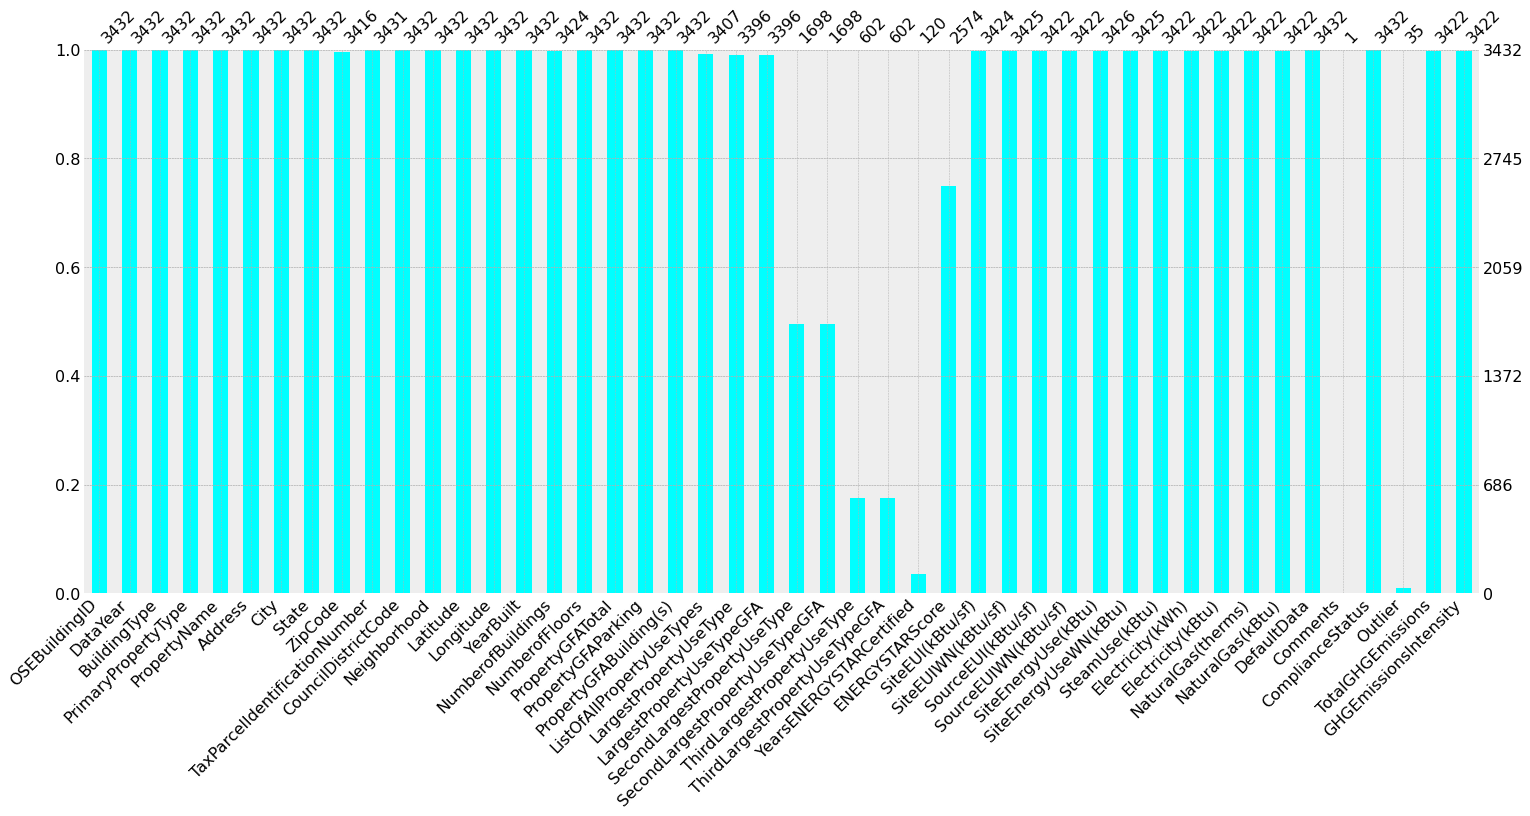

In [ ]:
# to visualize how many missing values

msno.bar(data, color='cyan')

___

# Work on variables

**1. Removal of irrelevant and insufficiently informed variables**

We can start by deleting the rows listed as outliers before deleting the column. We can also delete the Comments and the YearsENERGYSTARCertified column which is very lightly filled and which does not seem to be of much use.

In [ ]:
data = data[data['Outlier'].isnull()] 
data = data.drop(['Outlier', 'YearsENERGYSTARCertified', 'Comments'], axis=1)
display(data.shape)

(3397, 43)

In [ ]:
# to clean up my dataset, I adopt the method to Keep only lignes where 85% or more valid data is available

data = data.dropna(how='any',axis=0,thresh=data.shape[1]*0.85)
data.shape

(3367, 43)

We eliminate also negative values ​​of numeric variables.

In [ ]:
num_var= ['OSEBuildingID','DataYear', 'ZipCode','CouncilDistrictCode','YearBuilt','NumberofBuildings','NumberofFloors',
               'PropertyGFATotal','PropertyGFAParking','PropertyGFABuilding(s)','LargestPropertyUseTypeGFA',
               'ENERGYSTARScore','SiteEUI(kBtu/sf)',
               'SiteEUIWN(kBtu/sf)','SourceEUI(kBtu/sf)','SourceEUIWN(kBtu/sf)','SiteEnergyUse(kBtu)','SiteEnergyUseWN(kBtu)','SteamUse(kBtu)','Electricity(kWh)',
               'Electricity(kBtu)','NaturalGas(kBtu)','TotalGHGEmissions','GHGEmissionsIntensity']
for column in num_var:
    negatives_values = data[data[column] < 0]
    if(negatives_values.shape[0]>0):
        print(column)
        data.drop(negatives_values.index)

SourceEUIWN(kBtu/sf)
Electricity(kWh)
Electricity(kBtu)
TotalGHGEmissions
GHGEmissionsIntensity


**2. Removal of buildings intended for housing**

Since it is specified in the project that only buildings not intended for habitation will be studied. We are therefore going to delete all the lines corresponding to dwellings based on The variables :

BuildingType, PrimaryPropertyType, ListOfAllPropertyUseTypes, LargestPropertyUseType, SecondLargestPropertyUseType

All of these variables contain values ​​that refer to residential buildings, especially those containing the word 'family'. Ex: "Multifamily Housing" All the lines containing this word in one of the above variables are removed.

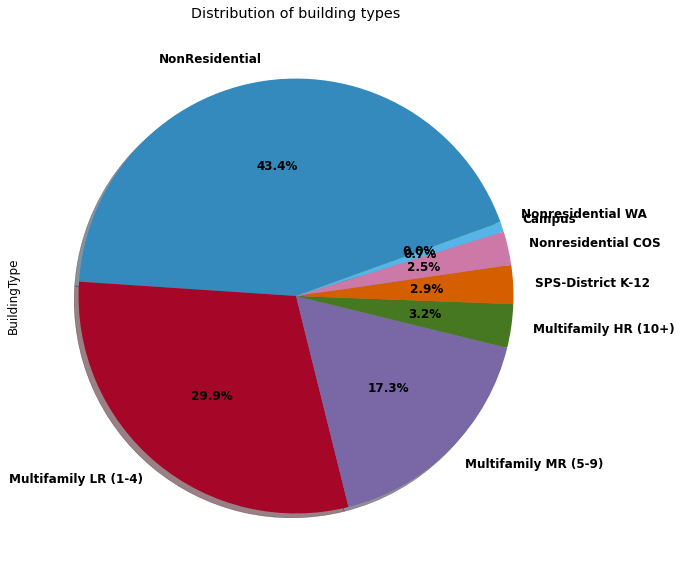

In [ ]:
data["BuildingType"].value_counts(normalize=True).plot(kind='pie',figsize=(15,10), title='Distribution of building types',
                                                       autopct='%1.1f%%', shadow=True, startangle=20,
                                                      textprops=dict(color="black",size=12, weight="bold"))


In [ ]:
# Removal of lines containing the word "family" in categorical variables

data = data[(data['BuildingType'].str.contains("family") == False)
                   & (data['PrimaryPropertyType'].str.contains("family") == False)
                   & (data['ListOfAllPropertyUseTypes'].str.contains("family") == False)
                   & (data['LargestPropertyUseType'].str.contains("family") == False)
                   & (data['SecondLargestPropertyUseType'].str.contains("family") == False)
                   ]

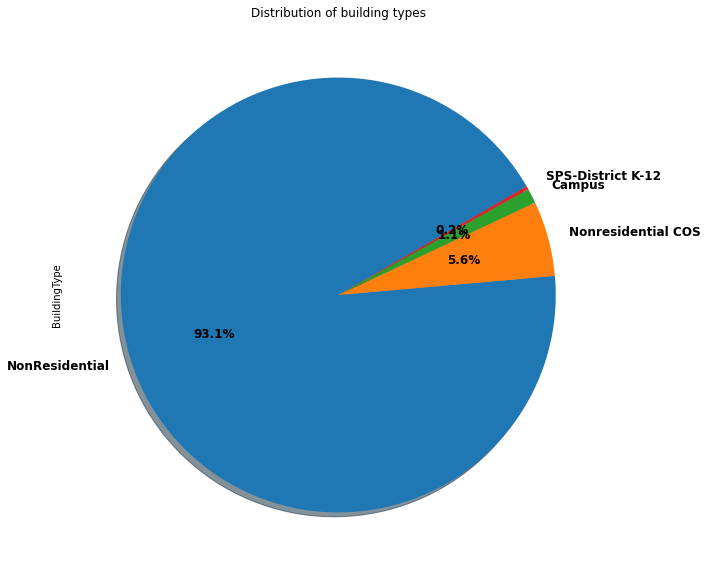

In [ ]:
data["BuildingType"].value_counts(normalize=True).plot(kind='pie',figsize=(15,10), title='Distribution of building types',
                                                       autopct='%1.1f%%', shadow=True, startangle=30,
                                                      textprops=dict(color="black",size=12, weight="bold"))

**Vocabulary**

Now that we've roughed up and refined the dataset, let's detail the acronyms used in the columns a bit:

GHG: greenhouse gas emissions.

OSE: Seattle Office of Sustainability and Environment.

EUI: Energy Use Intensity.

kBtu: kilo-British thermal unit, 1 kWh = 3.412 kBtu.

sf: square feet, 1m² = 10.7639sf.

WN: weather-normalized, standardized with respect to climatic conditions.

GFA: Gross floor area - The total covered floor area (by a roof, even without a wall) contained in the building.

therm: energy measurement 1thm = 100000Btu.

**3. Removal of variables with unwanted units**

To stay in the English unit KBtu, we will remove the column in kWh and uniformly with the rest of the columns.

In [ ]:
data = data.drop(['Electricity(kWh)', 'NaturalGas(therms)'], axis=1)
data.shape

(822, 41)

**4. Variable DefaultData**

In [ ]:
data['DefaultData'].value_counts()

False    806
No         9
True       5
Yes        2
Name: DefaultData, dtype: int64

In [ ]:
data.loc[data["DefaultData"] == True, "DefaultData"] = 'Yes'
data.loc[data["DefaultData"] == False, "DefaultData"] = 'No'

In [ ]:
data['DefaultData'].value_counts()

No     815
Yes      7
Name: DefaultData, dtype: int64

**5. Variable ComplianceStatus**

In [ ]:
data['ComplianceStatus'].unique()

array(['Compliant', 'Error - Correct Default Data', 'Non-Compliant'],
      dtype=object)

In [ ]:
print("Nombre de ligne identifiées comme non conforme : {}.".format(data[data['ComplianceStatus'] != "Compliant"].shape[0]))

Nombre de ligne identifiées comme non conforme : 6.


In [ ]:
data = data[data['ComplianceStatus'] == "Compliant"]

**6. Removal of highly correlated variables**

Text(0.5, 0.98, 'Clustermap of dataset')

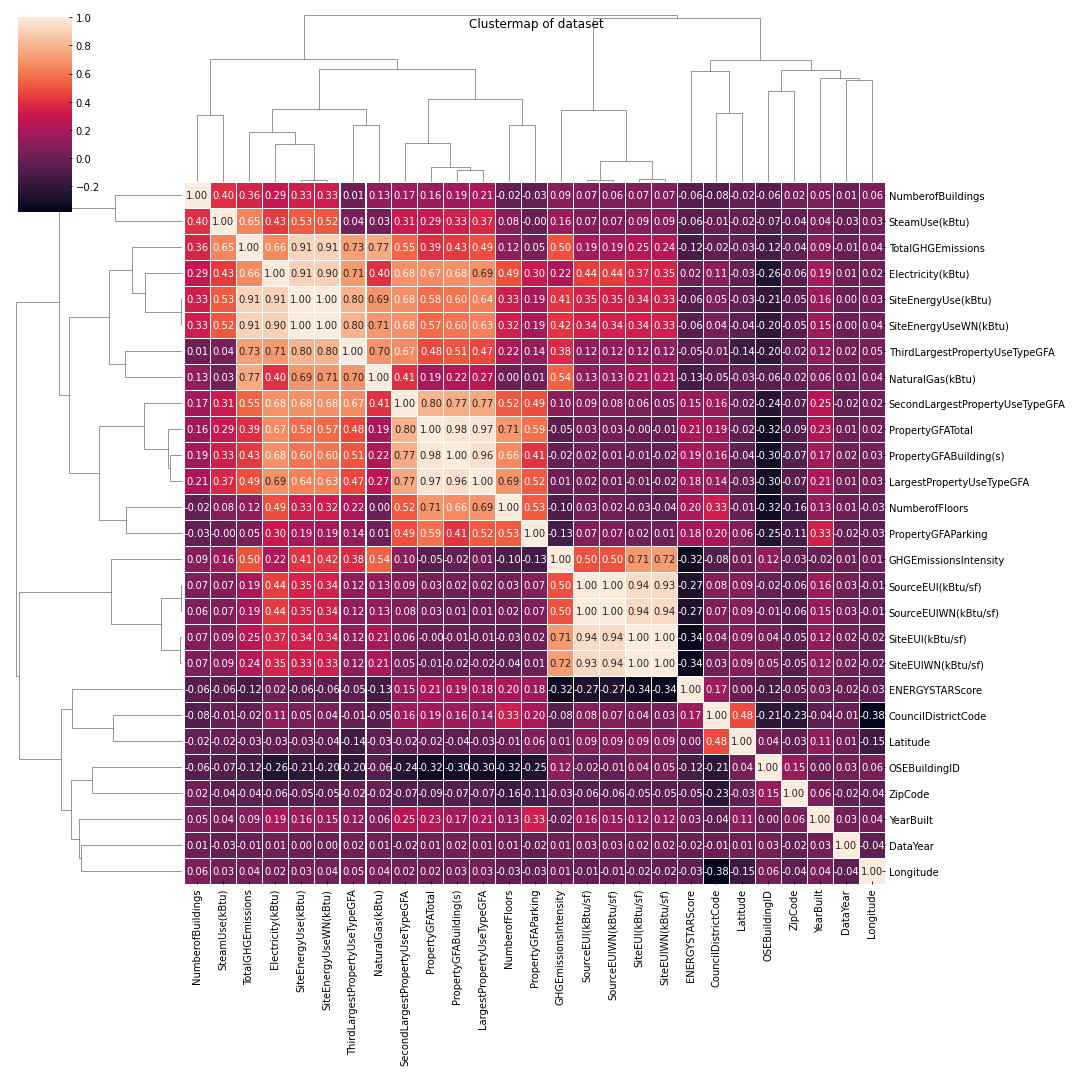

In [ ]:
# Correlation matrix of variables 

import seaborn as sns
sns.clustermap(data.corr(), annot=True, linewidths=0.1, fmt='.2f', figsize=(15, 15)).fig.suptitle('Clustermap of dataset') 

In [ ]:
# Removal of highly correlated variables
data.drop(['SiteEnergyUseWN(kBtu)','SourceEUIWN(kBtu/sf)',
                'SiteEUIWN(kBtu/sf)'], axis=1, inplace=True)

**7. Removal of duplicates**

In the context of our models, the variables to be predicted are the building's energy consumption (SiteEnergyUse (kBtu)) and its CO2 emissions (TotalGHGEmissions). Some lines have missing items on these variables, so we are going to remove them:

In [ ]:
# Removal of duplicate lines
data.drop_duplicates(inplace=True)

# Investigation of variables

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 816 entries, 312 to 3375
Data columns (total 38 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    816 non-null    int64  
 1   DataYear                         816 non-null    int64  
 2   BuildingType                     816 non-null    object 
 3   PrimaryPropertyType              816 non-null    object 
 4   PropertyName                     816 non-null    object 
 5   Address                          816 non-null    object 
 6   City                             816 non-null    object 
 7   State                            816 non-null    object 
 8   ZipCode                          809 non-null    float64
 9   TaxParcelIdentificationNumber    816 non-null    object 
 10  CouncilDistrictCode              816 non-null    int64  
 11  Neighborhood                     816 non-null    object 
 12  Latitude           

**Numeric variables**

In [ ]:
data[['PropertyGFATotal',
      'PropertyGFAParking',
      'PropertyGFABuilding(s)']] = data[['PropertyGFATotal',
                                         'PropertyGFAParking',
                                         'PropertyGFABuilding(s)']].astype(float)

In [ ]:
# Selection of numeric variables
var_num = list(data.select_dtypes(include='float64').columns)

In [ ]:
print("The numeric variables are as follows : \n")
for var in var_num :
    print(var)

The numeric variables are as follows : 

ZipCode
Latitude
Longitude
NumberofBuildings
NumberofFloors
PropertyGFATotal
PropertyGFAParking
PropertyGFABuilding(s)
LargestPropertyUseTypeGFA
SecondLargestPropertyUseTypeGFA
ThirdLargestPropertyUseTypeGFA
ENERGYSTARScore
SiteEUI(kBtu/sf)
SourceEUI(kBtu/sf)
SiteEnergyUse(kBtu)
SteamUse(kBtu)
Electricity(kBtu)
NaturalGas(kBtu)
TotalGHGEmissions
GHGEmissionsIntensity


In [ ]:
# Removal of geographic coordinates from the list of numeric variables
var_num = [e for e in var_num if e not in ('Latitude', 'Longitude')]

# Dataset containing only numeric variables
df_num = data[var_num]

In [ ]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 816 entries, 312 to 3375
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ZipCode                          809 non-null    float64
 1   NumberofBuildings                816 non-null    float64
 2   NumberofFloors                   816 non-null    float64
 3   PropertyGFATotal                 816 non-null    float64
 4   PropertyGFAParking               816 non-null    float64
 5   PropertyGFABuilding(s)           816 non-null    float64
 6   LargestPropertyUseTypeGFA        816 non-null    float64
 7   SecondLargestPropertyUseTypeGFA  816 non-null    float64
 8   ThirdLargestPropertyUseTypeGFA   317 non-null    float64
 9   ENERGYSTARScore                  490 non-null    float64
 10  SiteEUI(kBtu/sf)                 816 non-null    float64
 11  SourceEUI(kBtu/sf)               816 non-null    float64
 12  SiteEnergyUse(kBtu)

**Categorical variables**

In [ ]:
# Converting to object

data['CouncilDistrictCode'] = data['CouncilDistrictCode'].astype(object)
data['YearBuilt'] = data['YearBuilt'].astype(object)

In [ ]:
# Selection of categorical variables
var_cat = list(data.select_dtypes(include='object').columns)

In [ ]:
print("The categorical variables are as follows : \n")
for var in var_cat :
    print(var)

The categorical variables are as follows : 

BuildingType
PrimaryPropertyType
PropertyName
Address
City
State
TaxParcelIdentificationNumber
CouncilDistrictCode
Neighborhood
YearBuilt
ListOfAllPropertyUseTypes
LargestPropertyUseType
SecondLargestPropertyUseType
ThirdLargestPropertyUseType
DefaultData
ComplianceStatus


**1. Analysis of the distribution of numerical variables**

In [ ]:
# Visualization of the distribution of variables

def distribution(data):
    plt.figure(figsize=(13, 50))
    for i, col in enumerate(data) :
        plt.subplot(9,2,i+1)
        sns.distplot(data[col], color='green')
        plt.xlabel(col)
        plt.ylabel('Densité')
        plt.style.use('bmh')
    plt.show()   

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

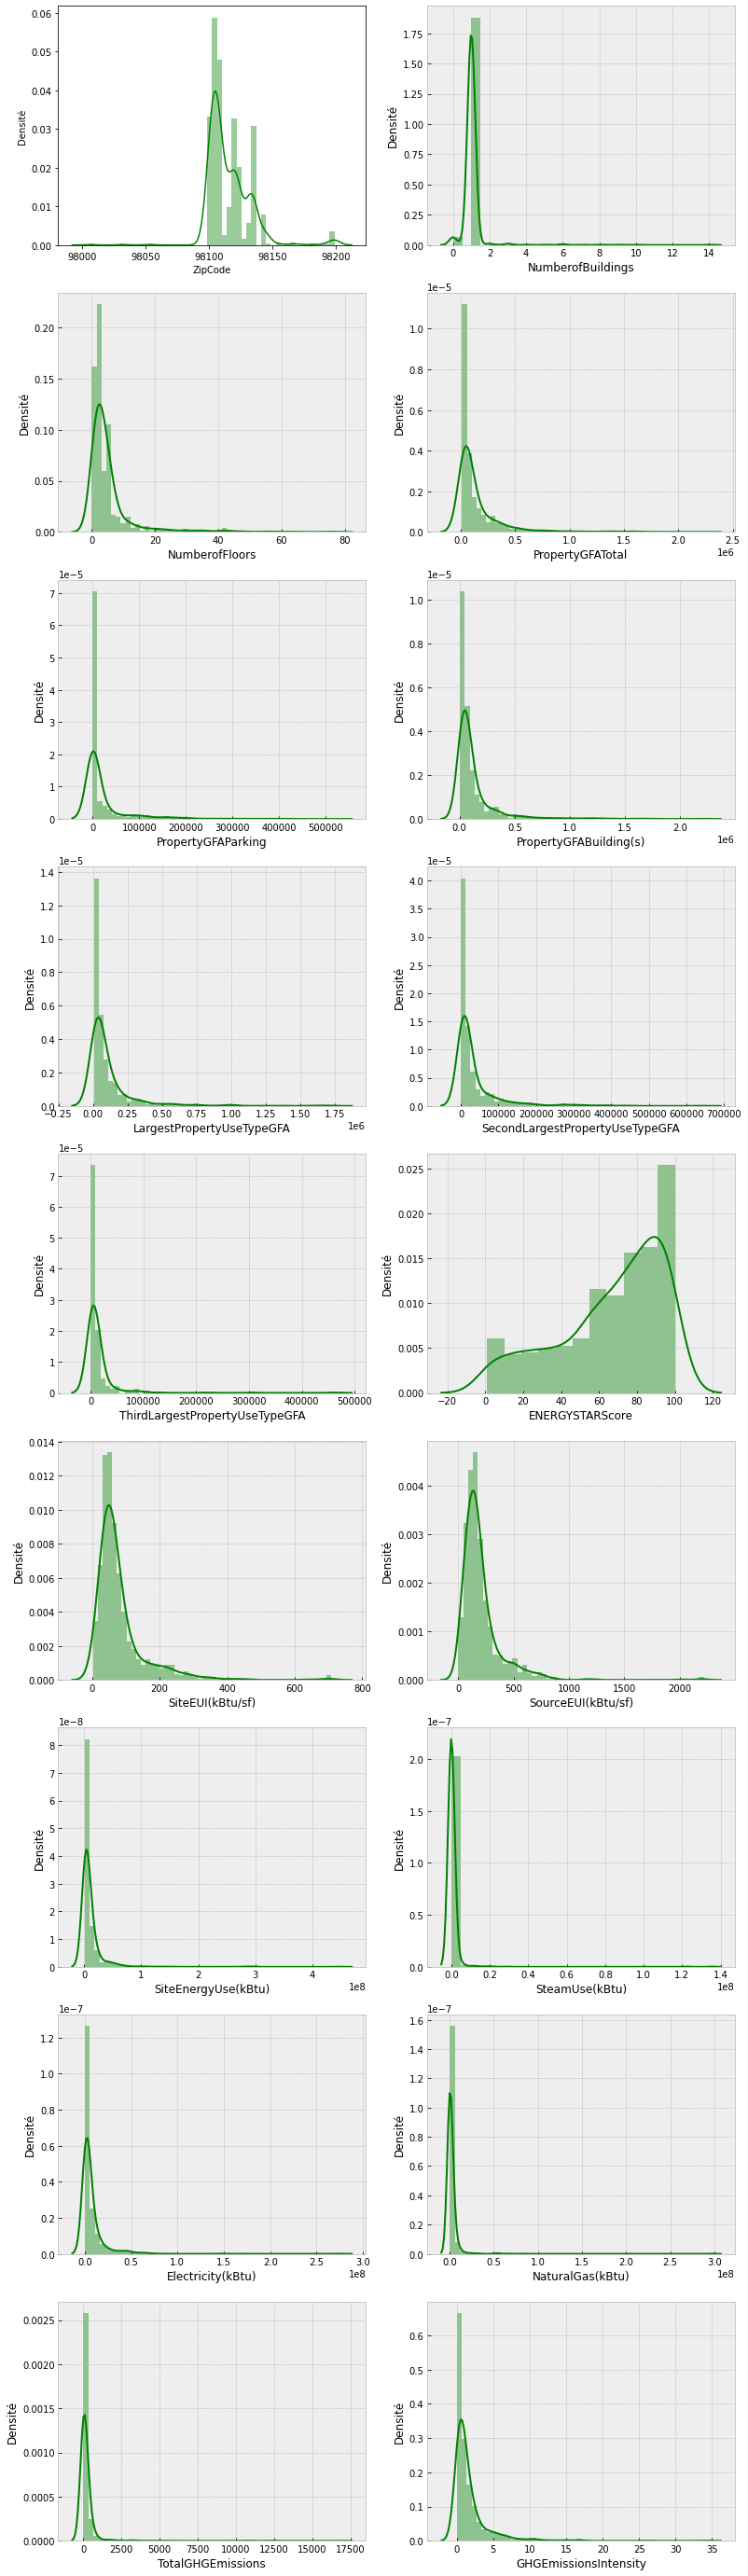

In [ ]:
# Visualization of the distribution of numerical variables

import matplotlib.pyplot as plt
import seaborn as sns
distribution(data[var_num])

Gross floor area (GFA) in real estate is the total floor area inside the building envelope, including the external walls, and excluding the roof. We notice that its distribution shows a lot of outliers.

We notice the presence of several outliers, which can be explained by the fact of the variation in the types of buildings studied, indeed an elementary school uses relatively little energy compared to a hospital.

A building's energy use refers to the energy required to operate and sustain the project once it's occupied. 


Most of the numeric variables are very flattened, in particular the two targets: 'SiteEnergyUse (kBtu)', 'TotalGHGEmissions'. A logarithmic transformation then a removal of the outliers will be applied to them.

It remains difficult without more in-depth knowledge of the variables to indicate whether the few strong values ​​observed correspond to outliers or to aberrants values.

The graph below represents the total energy used 'on site' per unit area in kBtu / sf for different types of buildings in the USA in 2003 and 2012. The maximum value observed is around 280 kBtu / sf (food service 2012).

The graph obtained on our dataset for the corresponding variable: SiteEUI (kbtu / sf) tells us that most buildings have a value of SiteEUI (kbtu / sf) between 0 and 200. So we can easily assume that the values beyond 300 are outliers.

Source : https://www.eia.gov/consumption/commercial/reports/2012/energyusage/#_ftn1











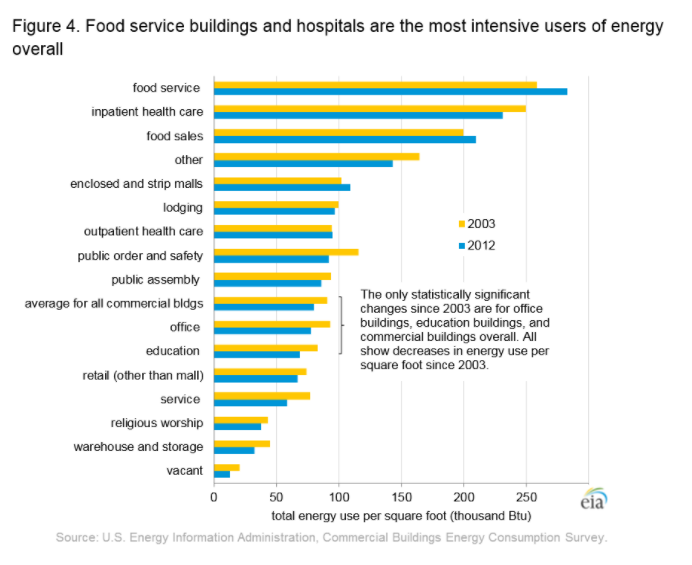

In [ ]:
# Removal of lines where the SiteEUI variable (kbtu / sf) is greater than 300
data = data[data['SiteEUI(kBtu/sf)'] < 300]

**Focus on targets**

Let us now look at the distribution of 2 variables 'SiteEnergyUse(kBtu)'and 'TotalGHGEmissions' according to the type of building.

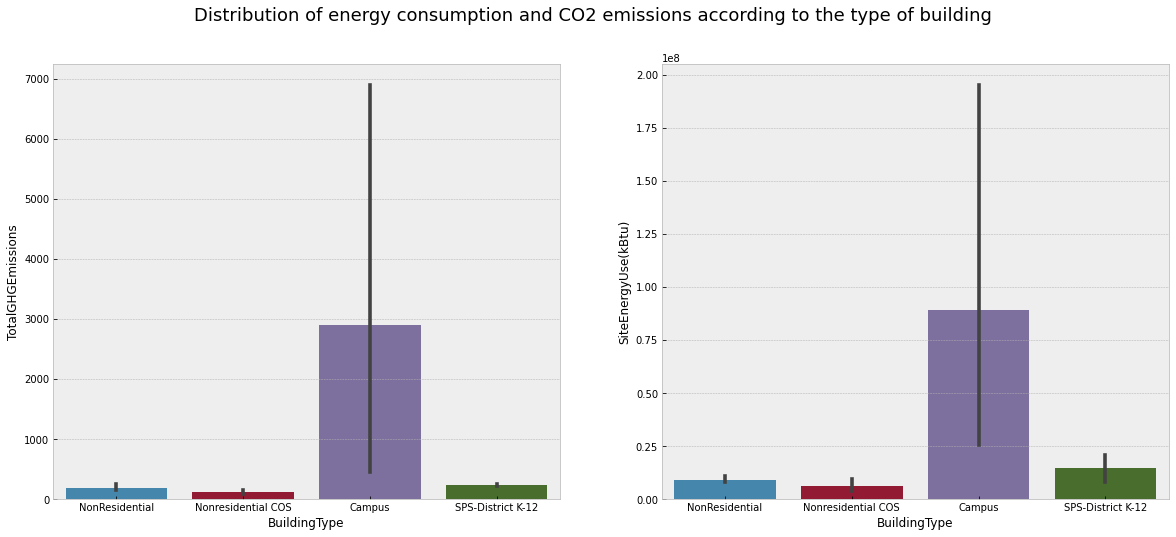

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
sns.barplot(x='BuildingType',y='TotalGHGEmissions',data=data, ax=axes[0])
sns.barplot(x='BuildingType',y='SiteEnergyUse(kBtu)',data=data, ax=axes[1])
plt.suptitle("Distribution of energy consumption and CO2 emissions according to the type of building",fontsize=18)
plt.show()

The campuses show the highest figures in terms of consumption and CO2 emissions. Now let's see if the age of buildings has an impact on CO2 emissions:

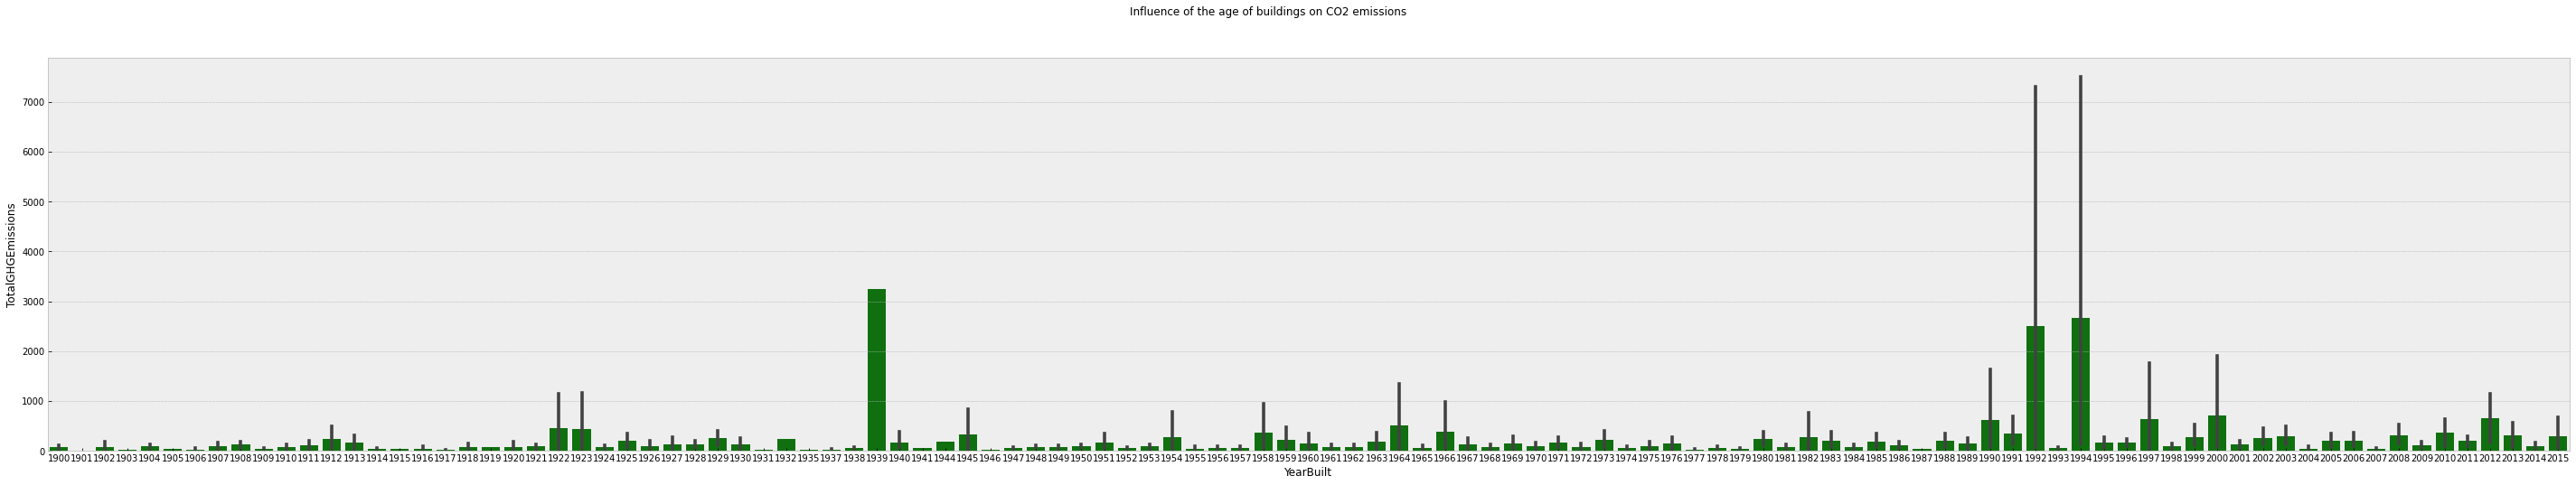

In [ ]:
fig, axes = plt.subplots( figsize=(50,8))
sns.barplot(data=data,x=data['YearBuilt'], y="TotalGHGEmissions", color = "green")
plt.suptitle('Influence of the age of buildings on CO2 emissions')
plt.show()

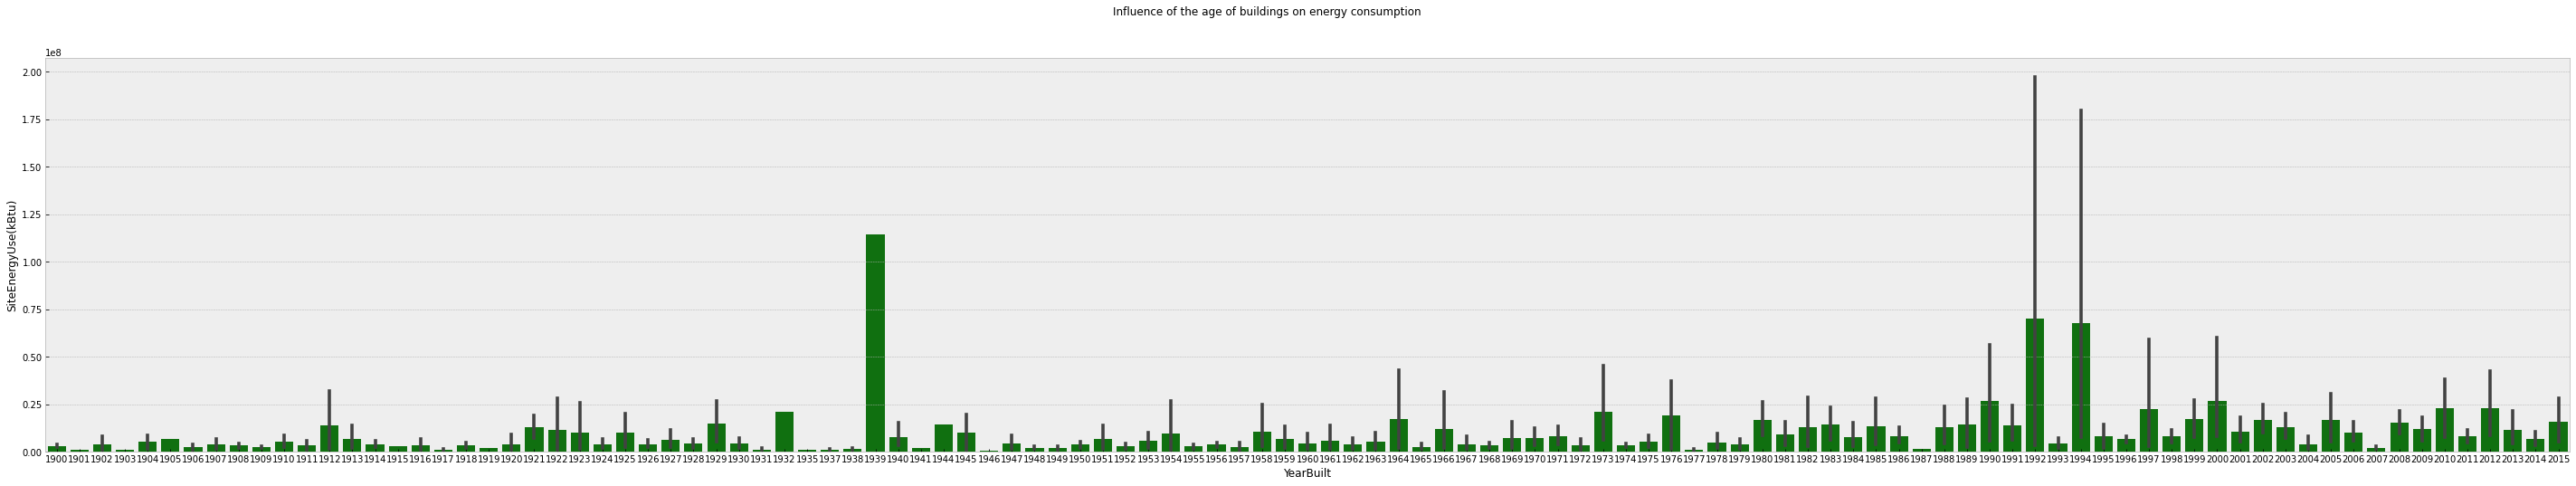

In [ ]:
fig, axes = plt.subplots( figsize=(50,8))
sns.barplot(data=data,x=data['YearBuilt'], y="SiteEnergyUse(kBtu)", color = "green" )
plt.suptitle('Influence of the age of buildings on energy consumption')
plt.show()

We do not notice an effect of the age of the building on these two variables.

Let us now look at the distribution of 2 variables 'SiteEnergyUse(kBtu)' and 'TotalGHGEmissions' in general.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(

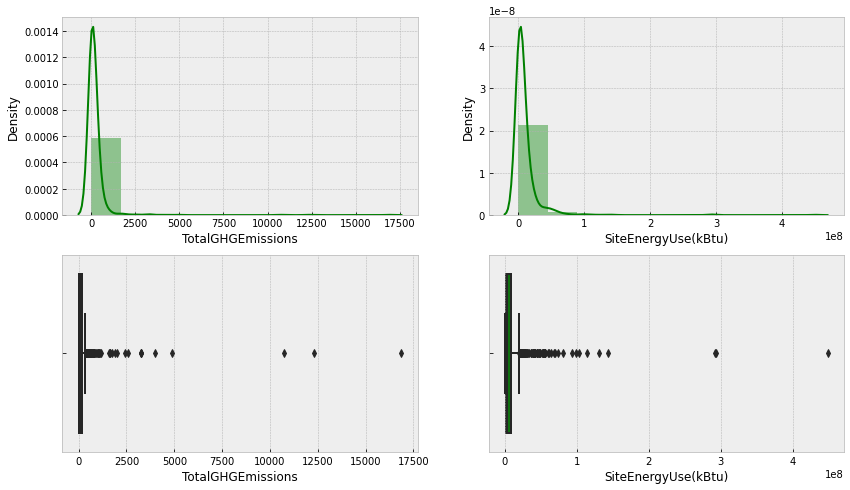

In [ ]:
# Distribution and boxplot of targets

plt.style.use('bmh')

fig = plt.figure(1, figsize=(14, 8))
for i,label in enumerate(["TotalGHGEmissions", "SiteEnergyUse(kBtu)"]) :
    plt.subplot(2,2,i+1)
    sns.distplot(data[label], bins=int(1 + np.log2(len(data))), color='green') # Sturges’ Rule
    plt.subplot(2,2,i+3)
    sns.boxplot(data[label], orient="h", color='green')
plt.show()
plt.suptitle=('Targets distibution')

Logarithmic transformation is a convenient means of transforming a highly skewed variable into a more normalized dataset. When modeling variables with non-linear relationships, the chances of producing errors may also be skewed negatively. In theory, we want to produce the smallest error possible when making a prediction, while also taking into account that we should not be overfitting the model.

Overfitting occurs when there are too many dependent variables in play that it does not have enough generalization of the dataset to make a valid prediction. Using the logarithm of one or more variables improves the fit of the model by transforming the distribution of the features to a more normally-shaped bell curve.

https://dev.to/rokaandy/logarithmic-transformation-in-linear-regression-models-why-when-3a7c

**Log target transformation**

In [ ]:
targets = ['SiteEnergyUse(kBtu)', 'TotalGHGEmissions']

In [ ]:
# Removal of null lines
data = data[~((data['SiteEnergyUse(kBtu)'].isnull()) | (data['TotalGHGEmissions'].isnull()))]

In [ ]:
from sklearn.preprocessing import FunctionTransformer
Mon_transformer = FunctionTransformer (func = np.log1p, 
                                       inverse_func = np.expm1)

In [ ]:
data_targets_log = Mon_transformer.fit_transform (data[targets])

In [ ]:
data_targets_log = data_targets_log.rename(columns={"SiteEnergyUse(kBtu)": "SiteEnergyUse(kBtu)log","TotalGHGEmissions": "TotalGHGEmissionslog"})

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(

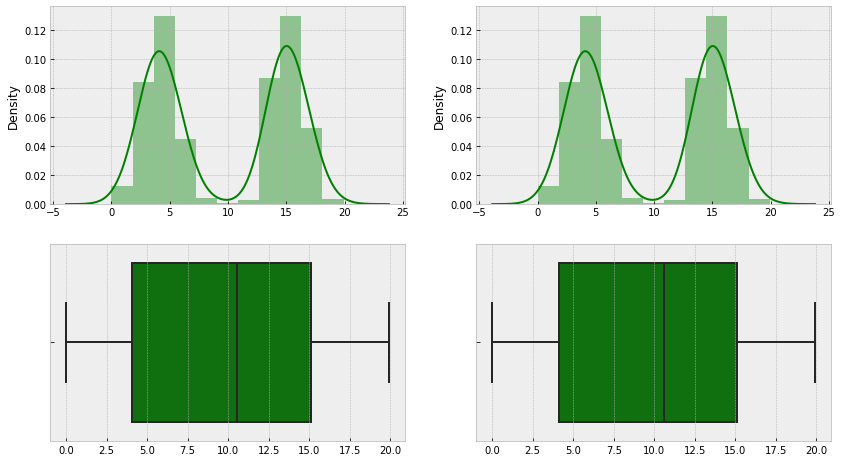

In [ ]:
# Distribution and boxplot of targets after log transformation and standardization

plt.style.use('bmh')
fig = plt.figure(1, figsize=(14, 8))
for i,label in enumerate(["TotalGHGEmissionslog", "SiteEnergyUse(kBtu)log"]) :
  plt.subplot(2,2,i+1)
  sns.distplot(data_targets_log[np.isfinite(data_targets_log[label])].values, color='green')
  plt.subplot(2,2,i+3)
  sns.boxplot(data_targets_log[np.isfinite(data_targets_log[label])].values, orient="h", color='green')
plt.show()

In [ ]:
# Dataframe with transformed targets
data_log = pd.concat([data, data_targets_log], axis=1)

**Removing outliers from targets**

The removal of outliers is carried out with the use of the interquartile range (IQR). The outliers values ​​are located outside the "whiskers", ie beyond Q3 + 1.5 (Q3-Q1) and below Q1 - 1.5 (Q3-Q1). However, to be able to apply this principle, the distribution of the variable must approach a normal distribution, which is why a transformation (log transformation via PowerTransformer) is applied beforehand.

In [ ]:
# Calculation of quartiles and IQR for energy

Q1 = np.percentile(data_log["SiteEnergyUse(kBtu)log"], 25)
Q3 = np.percentile(data_log["SiteEnergyUse(kBtu)log"], 75)

born_sup_energy = Q3 + 1.5*(Q3-Q1)
born_inf_energy = Q1 - 1.5*(Q3-Q1)

In [ ]:
# Calculation of quartiles and IQR for CO2

Q1 = np.percentile(data_log["TotalGHGEmissionslog"], 25)
Q3 = np.percentile(data_log["TotalGHGEmissionslog"], 75)

born_sup_co2 = Q3 + 1.5*(Q3-Q1) 
born_inf_co2 = Q1 - 1.5*(Q3-Q1)

In [ ]:
# Withdrawal of outliers from IQRs

data_log = data_log[(data_log["SiteEnergyUse(kBtu)log"] < born_sup_energy)
            & (data_log["SiteEnergyUse(kBtu)log"] > born_inf_energy)]

data_log = data_log[(data_log["TotalGHGEmissionslog"] < born_sup_co2)
            & (data_log["TotalGHGEmissionslog"] > born_inf_co2)]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(

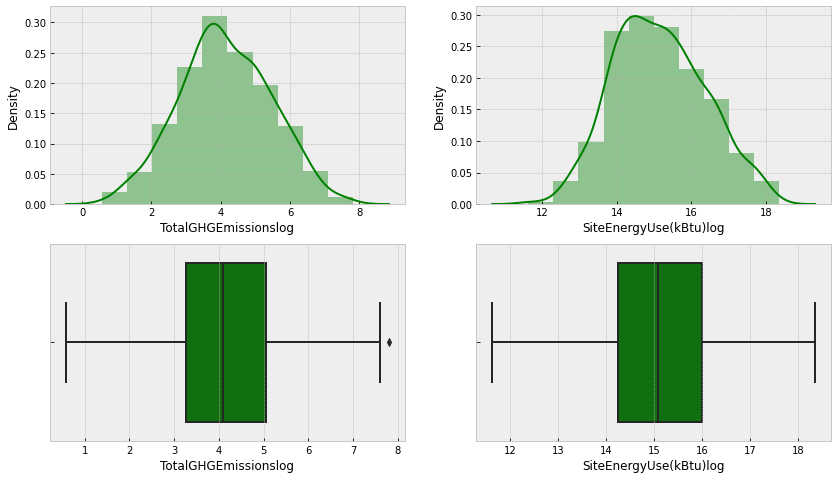

In [ ]:
# Visualization of the distribution of targets after removal of outliers

fig = plt.figure(1, figsize=(14, 8))
for i,label in enumerate(["TotalGHGEmissionslog", "SiteEnergyUse(kBtu)log"]) :
    plt.subplot(2,2,i+1)
    sns.distplot(data_log[label], bins=int(1 + np.log2(len(data_log))), color='green')
    plt.subplot(2,2,i+3)
    sns.boxplot(data_log[label], orient="h", color='green')
plt.show()

**2. Analysis of categorical variables**

In [ ]:
data[var_cat].head(2)

,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,ListOfAllPropertyUseTypes,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,DefaultData,ComplianceStatus
312,NonResidential,Large Office,KING BROADCASTING,333 DEXTER AVE N,SEATTLE,WA,1991200870,7,LAKE UNION,1947,"Data Center, Office, Other, Parking, Restaurant",Office,Parking,Other,No,Compliant
358,NonResidential,Small- and Mid-Sized Office,ASIAN COUNSELING and REFERRAL SERVICE BUILDING,3639 MARTIN LUTHER KING JR WAY S,SEATTLE,WA,1426300170,2,GREATER DUWAMISH,2008,"Office, Parking",Office,Parking,NaN,Yes,Compliant


In [ ]:
for var in var_cat :
    print(var)
    print(data[var].nunique())

BuildingType
4
PrimaryPropertyType
22
PropertyName
797
Address
793
City
2
State
1
TaxParcelIdentificationNumber
772
CouncilDistrictCode
7
Neighborhood
17
YearBuilt
111
ListOfAllPropertyUseTypes
290
LargestPropertyUseType
43
SecondLargestPropertyUseType
46
ThirdLargestPropertyUseType
37
DefaultData
2
ComplianceStatus
1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


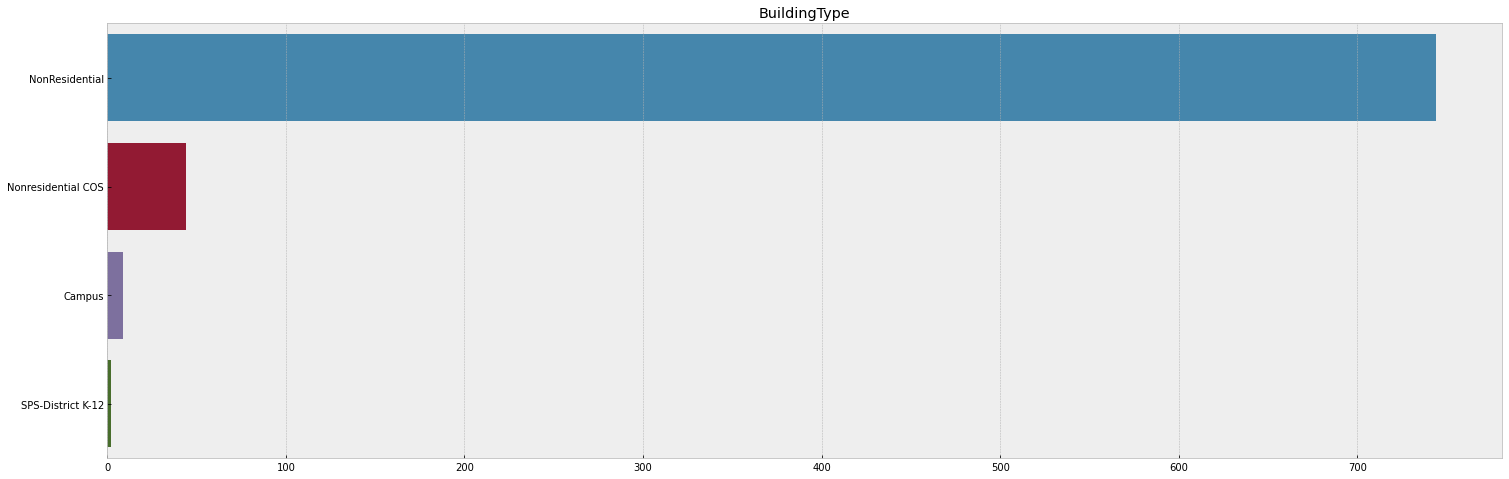

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


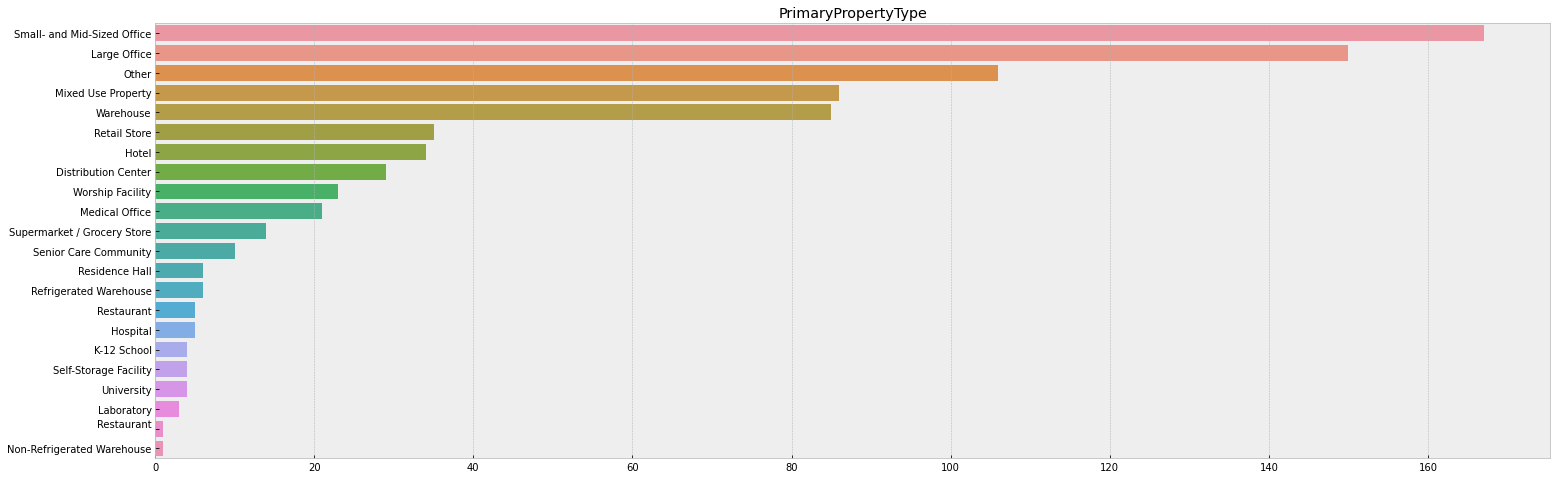

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


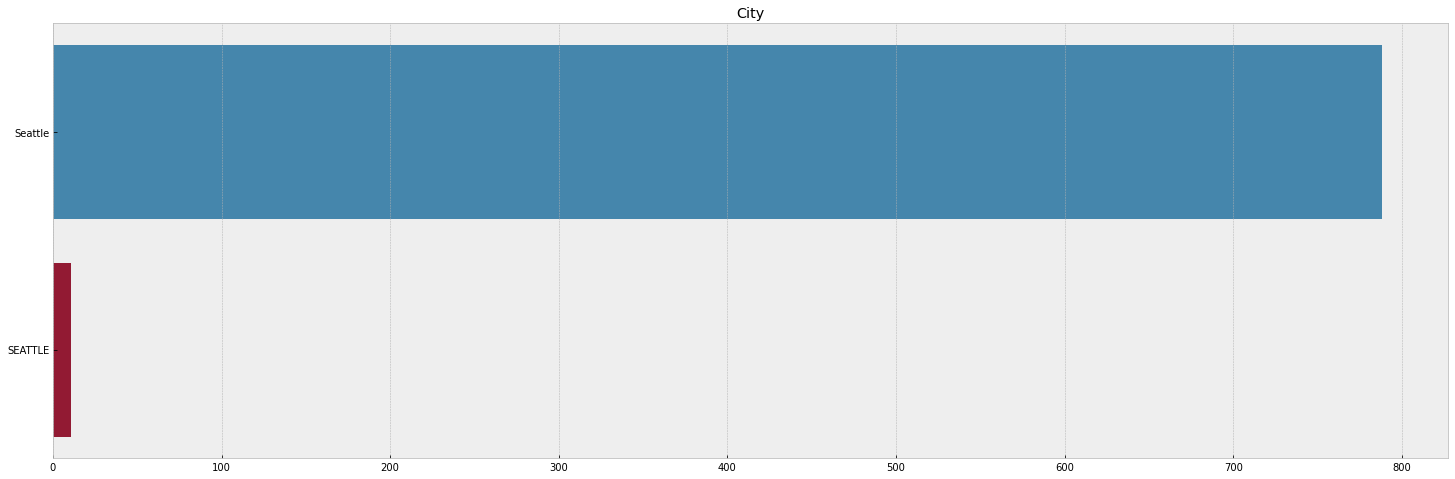

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


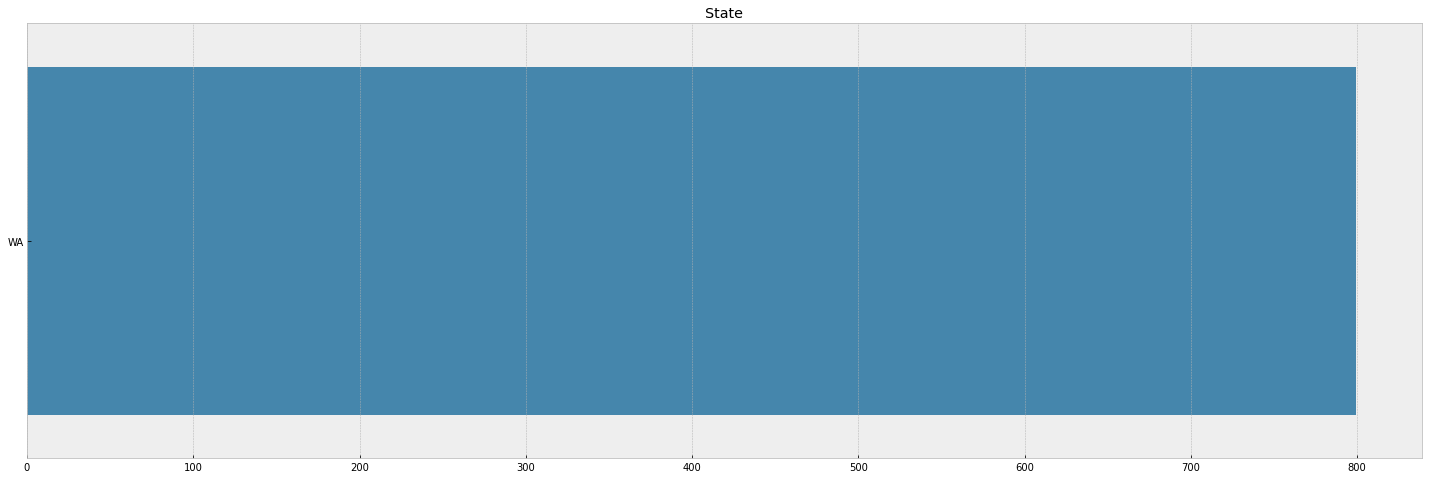

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


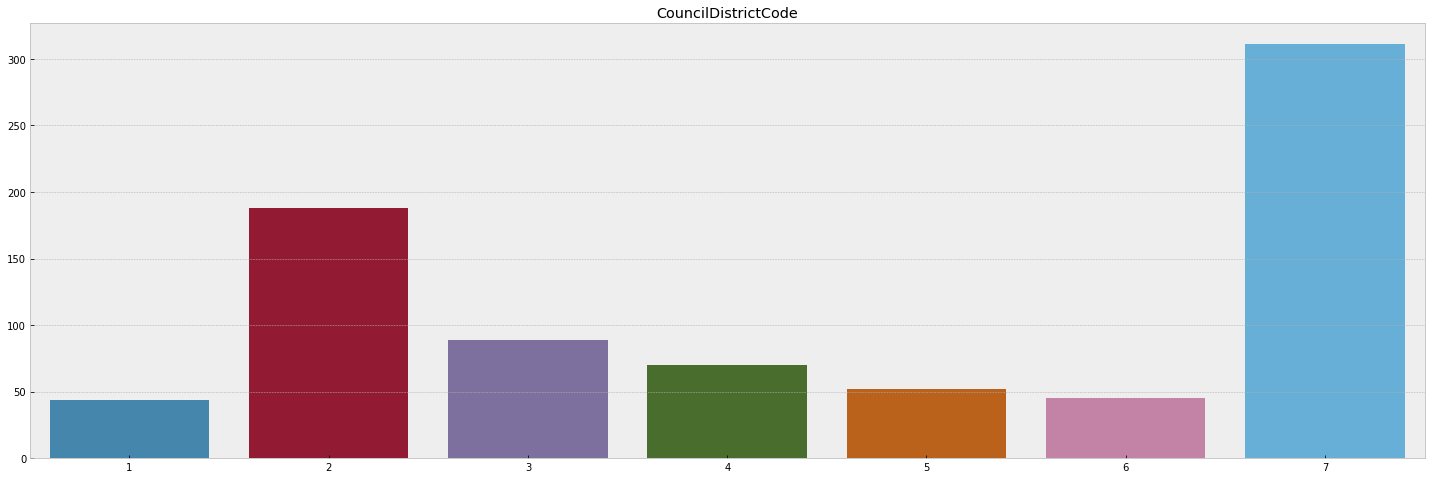

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


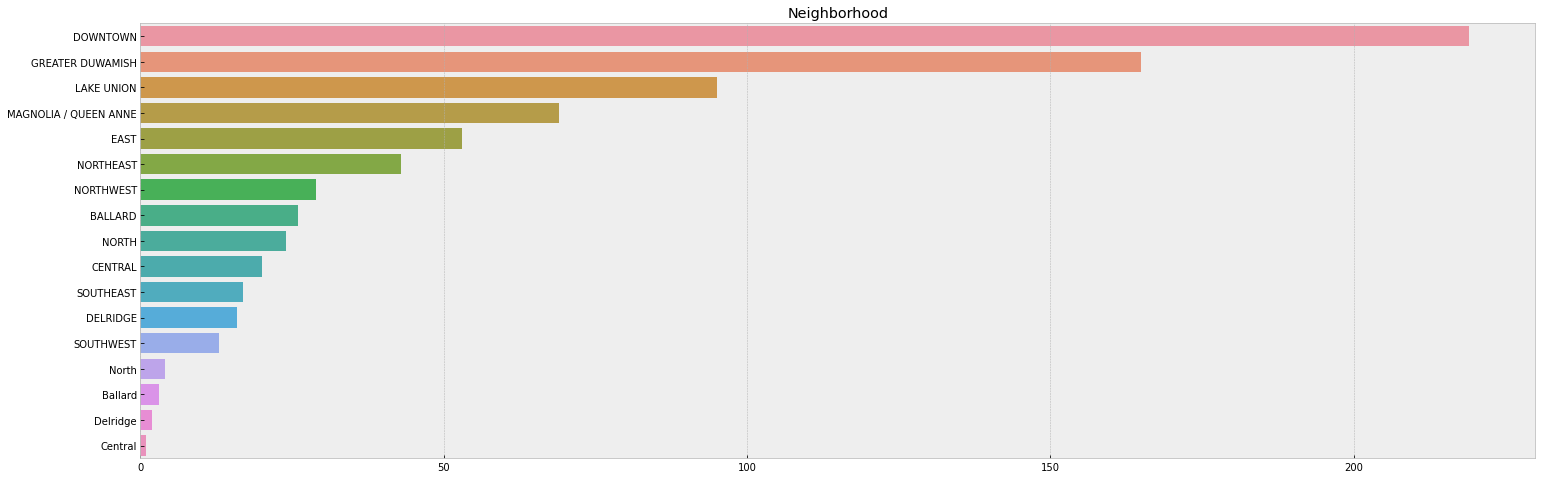

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


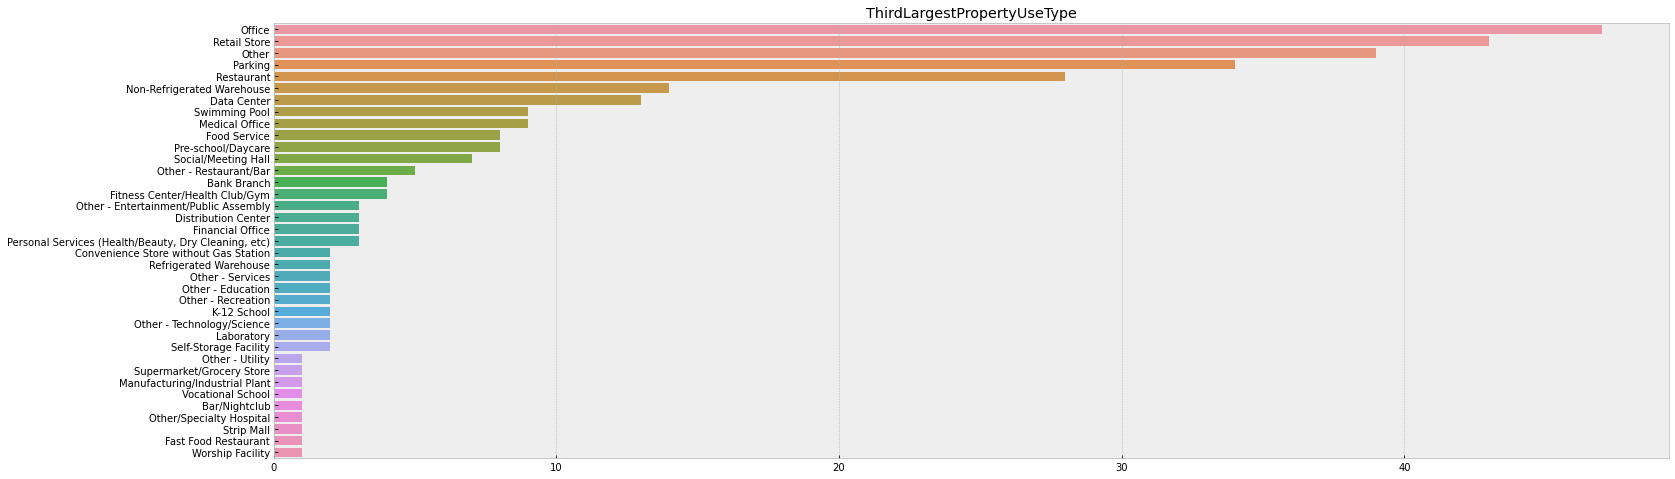

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


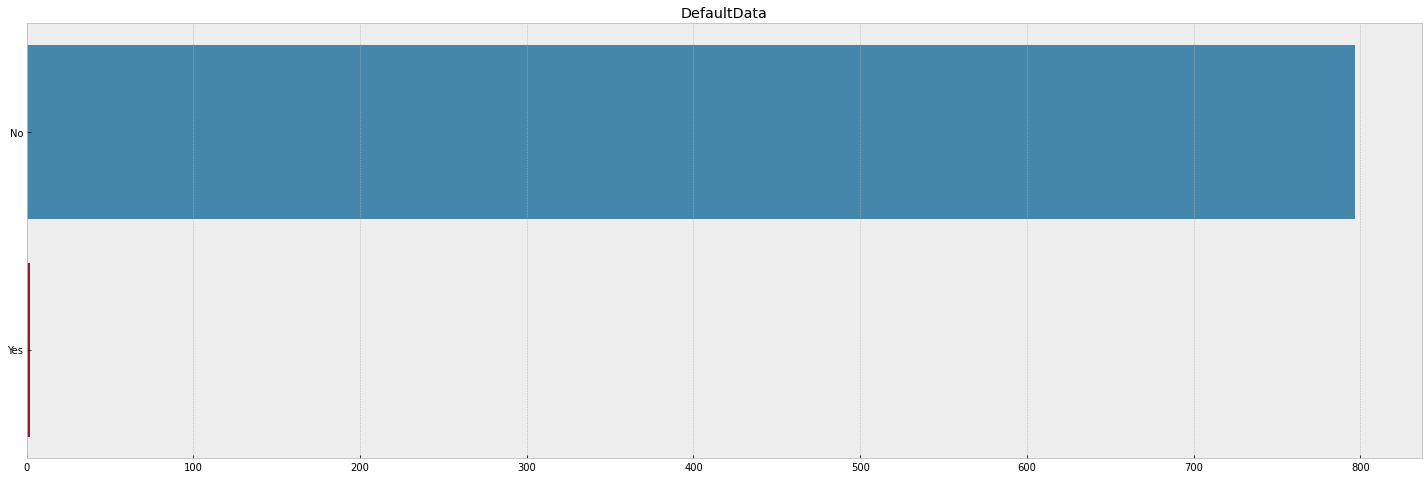

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


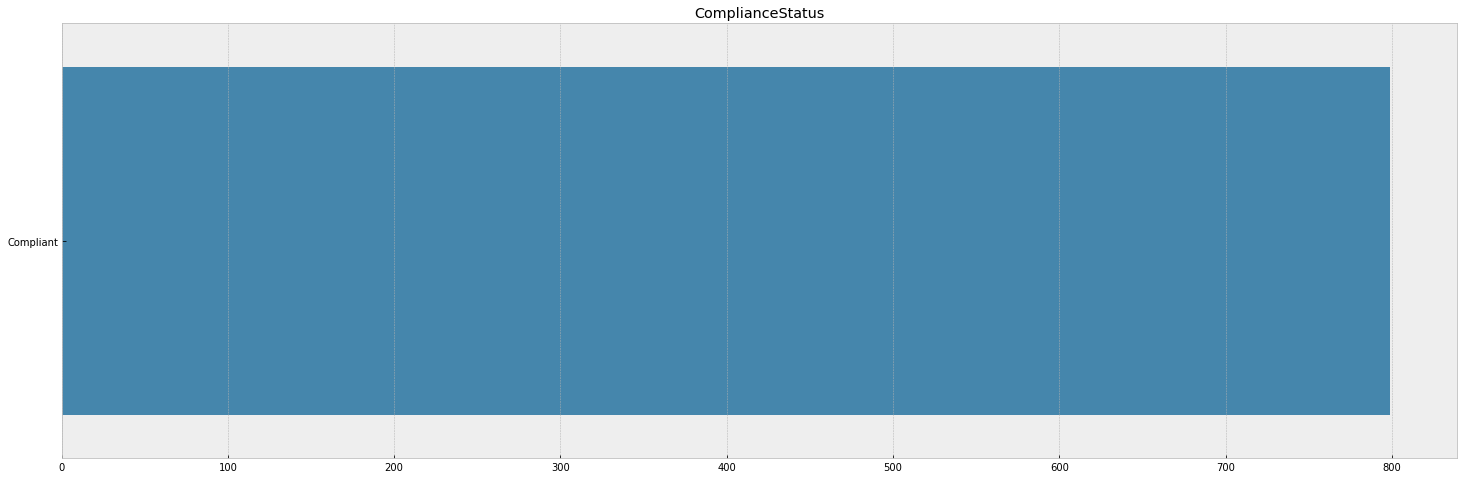

In [ ]:
# Visualization of categorical variables containing less than 40 unique values ​​for better visibility

var_cat_plot = list(data[var_cat].nunique()[
                    data[var_cat].nunique().values < 40].index)

for var in var_cat_plot:
    fig = plt.figure(1, figsize=(25, 8))
    df_cat = data[var].value_counts()
    plt.title(var)
    if var == 'CouncilDistrictCode':
        sns.barplot(df_cat.index, df_cat.values)
    else:
        sns.barplot(df_cat.values, df_cat.index)
    plt.show()

We are now going to convert the different surfaces (Buildings and Parking) into a percentage of the total surface and we will keep only these 2 variables by removing the variables LargestPropertyUseTypeGFA, SecondLargestPropertyUseTypeGFA, ThirdLargestPropertyUseTypeGFA, 'PropertyGFAParking', 'PropertyGFATotal.

In [ ]:
# We calculate the ratios

data_log['GFABuildingRate'] = (round((data_log['PropertyGFABuilding(s)']
                                  /data_log['PropertyGFATotal']),5))
data_log['GFAParkingRate'] = (round((data_log['PropertyGFAParking']
                                 /data_log['PropertyGFATotal']),5))

# We remove unnecessary variables

data_log = data_log.drop(['LargestPropertyUseTypeGFA', 
           'SecondLargestPropertyUseTypeGFA',
           'SecondLargestPropertyUseType',
           'ThirdLargestPropertyUseTypeGFA',
           'ThirdLargestPropertyUseType',
           'PropertyGFAParking',
           'PropertyGFATotal'],
         axis=1)

Now we are going to remove a few unimportant variables in the rest of the work.

In [ ]:
data_log = data_log.drop(['NumberofFloors','ZipCode', 'City', 'State','CouncilDistrictCode','ComplianceStatus','TaxParcelIdentificationNumber',
                  'DefaultData'], axis=1)

In [ ]:
data_log.head(2)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,SiteEnergyUse(kBtu)log,TotalGHGEmissionslog,GFABuildingRate,GFAParkingRate
312,442,2015,NonResidential,Large Office,KING BROADCASTING,333 DEXTER AVE N,LAKE UNION,47.621476,-122.343050,1947,1.0,155934.0,"Data Center, Office, Other, Parking, Restaurant",Office,59.0,105.8,332.3,16760217.0,0.0,16760914.0,0.0,116.84,0.23,16.634519,4.769328,0.80466,0.19534
358,499,2015,NonResidential,Small- and Mid-Sized Office,ASIAN COUNSELING and REFERRAL SERVICE BUILDING,3639 MARTIN LUTHER KING JR WAY S,GREATER DUWAMISH,47.570897,-122.297412,2008,1.0,55188.0,"Office, Parking",Office,76.0,81.1,169.8,4476997.0,0.0,2234200.0,2242889.0,134.69,1.63,15.314463,4.910373,0.72049,0.27951


___

# Energy consumption VS Characteristics of buildings



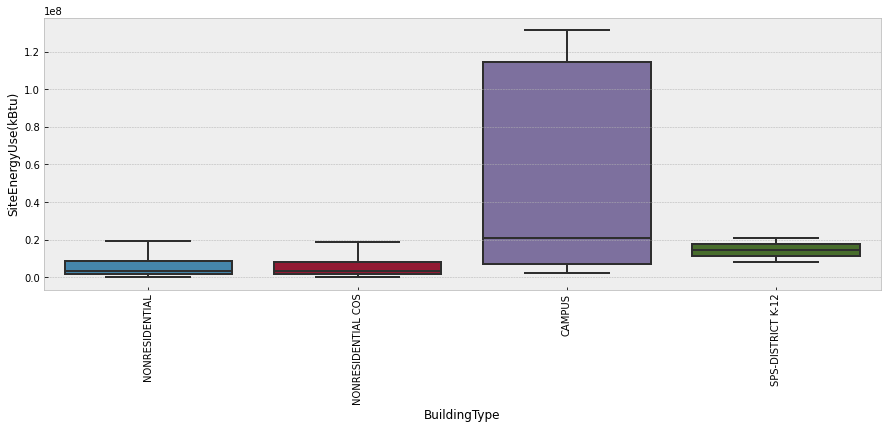

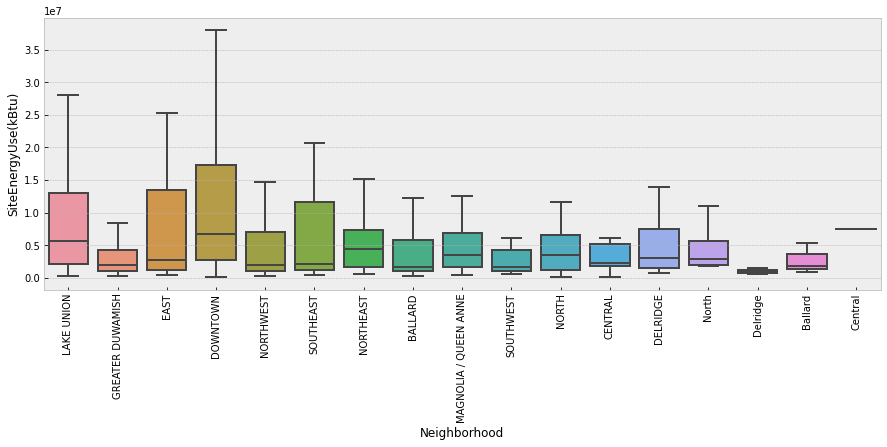

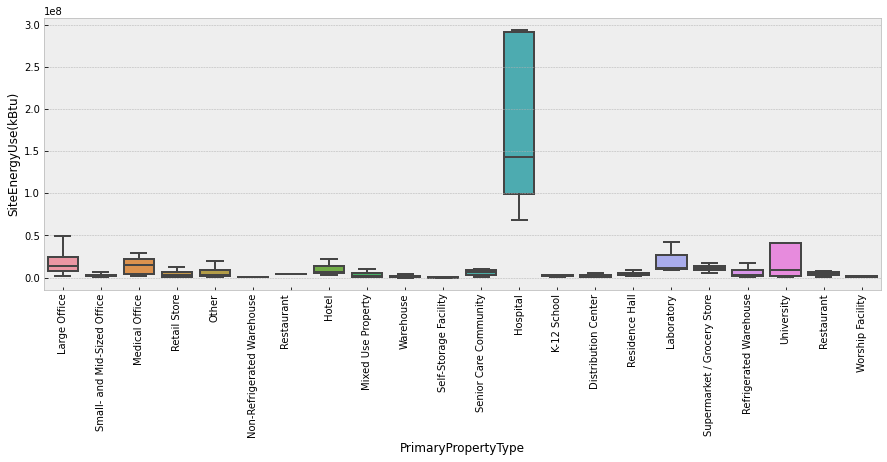

In [ ]:
liste = ['BuildingType', 'Neighborhood', 'PrimaryPropertyType']

for el in liste:
    plt.figure(1, figsize=(15,5))
    sns.boxplot(data=data, x=el , y="SiteEnergyUse(kBtu)", showfliers=False)
    plt.xticks(rotation=90)
    plt.show()

The main buildings consuming the most energy are those relating to education (Campus + SPS District K12) and to large offices and hospitals (medical office). They are located in the DownTown, the South East and the Lake Union area.

___

# Geographic analysis

In [ ]:
import folium
map_osm = folium.Map
map_osm = folium.Map(location=[data_log['Latitude'].mean(), data_log['Longitude'].mean()],zoom_start=11)
for i in range(0,len(data_log)):
    folium.Circle([data_log.iloc[i]['Latitude'],data_log.iloc[i]['Longitude']], 
                      popup=data_log.iloc[i]['Address'], radius =100).add_to(map_osm)
map_osm

The majority of the buildings studied are concentrated in the center along an east-west axis. 

___

# Exporting the dataset

In [ ]:
data_log.to_csv('dataset_clean_projet_4.csv')